### Dan Sokolsky
### ds3837@nyu.edu
### March 2, 2021
### Homework #2

### In this experiment, we explore The Markov Chain Monte Carlo (MCMC) Metropolis-Hastings
### algorithm and how a variety of variables affect the sampling scheme. We compare and plot
### samples we draw from a normal distribution vs. samples we arrive at via the Metropolis-Hastings
### sampling scheme.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal


histogram_bins = np.arange(-5, 5, 0.25)
number_of_trials = 100000


def get_invariant_mean(dimension):
    return np.zeros(dimension)


def get_invariant_standard_deviation():
    return 1.5


def get_uniform_sample():
    return np.random.uniform(0, 1)


def get_signed_distance(v: np.array, w: np.array):
    assert v.shape == w.shape, 'cannot compute sign of vectors of different dimension'

    dimension, = v.shape

    oriented_distance_matrix: np.array = np.identity(dimension)

    difference = v - w

    oriented_distance_matrix[0] = difference

    # notice that the determinant of the upper triangular oriented_distance_matrix will be
    # == oriented_distance_matrix[0][0] == difference[0]. If performance ever became an issue,
    # we could replace the computation of the determinant with difference[0]. In fact,
    # we could take the sign of any coordinate to denote orientation, for the purposes of
    # this simulation.
    return np.sign(np.linalg.det(oriented_distance_matrix)) * np.linalg.norm(difference)


def prepare_mcmc_samples(dimension, proposal_standard_deviation):
    invariant_mean = get_invariant_mean(dimension)
    invariant_standard_deviation = get_invariant_standard_deviation()
    invariant_mvn = get_mvn(dimension, invariant_mean, invariant_standard_deviation)
    proposal_variance = proposal_standard_deviation ** 2
    proposal_cov = proposal_variance * np.array(np.identity(dimension))

    # set initial proposal - all coordinates = 1
    current_proposal = np.ones(dimension)

    samples = [current_proposal]
    for _ in range(number_of_trials):
        proposal = np.random.multivariate_normal(current_proposal, proposal_cov)
        u = get_uniform_sample()
        alpha = invariant_mvn.pdf(proposal) / invariant_mvn.pdf(current_proposal)
        if u < alpha:
            samples.append(proposal)
            current_proposal = proposal
    return samples


def prepare_mcmc_samples_one_coordinate_at_a_time(dimension, proposal_standard_deviation):
    invariant_mean = get_invariant_mean(dimension)
    invariant_standard_deviation = get_invariant_standard_deviation()
    invariant_mvn = get_mvn(dimension, invariant_mean, invariant_standard_deviation)
    proposal_variance = proposal_standard_deviation ** 2
    proposal_cov = proposal_variance * np.array(np.identity(dimension))

    # set initial proposal - all coordinates = 1
    current_proposal = np.ones(dimension)

    samples = [current_proposal]
    for _ in range(int(np.round(number_of_trials / dimension))):
        for dim in range(dimension):
            proposal = np.copy(current_proposal)
            proposal[dim] = np.random.normal(proposal[dim], proposal_standard_deviation) 
            u = get_uniform_sample()
            alpha = invariant_mvn.pdf(proposal) / invariant_mvn.pdf(current_proposal)
            if u < alpha:
                samples.append(proposal)
                current_proposal = proposal
    return samples


def plot_histograms_by_distance(dimension, samples):
    # plot normalized histogram of amount of successful samples by distance from the invariant mean
    invariant_mean = get_invariant_mean(dimension)
    signed_distances = [get_signed_distance(x, invariant_mean) for x in samples]
    plt.hist(signed_distances, bins=histogram_bins, density=True, label='MCMC Sampling')

    # invariant normal distribution by distance
    plot_normal_distribution_by_distance(dimension, get_invariant_mean(dimension), get_invariant_standard_deviation())
    plt.xlabel('Distance from mean')
    plt.ylabel('Probability')
    plt.title(f'Probability by distance from mean\nNumber of dimension: {dimension}')
    plt.legend()
    plt.show()


def get_mvn(dimension, mean, standard_deviation):
    cov = (standard_deviation ** 2) * np.array(np.identity(dimension))
    mvn = multivariate_normal(mean, cov)
    return mvn


def plot_normal_distribution_by_distance(dimension, mean, standard_deviation):
    cov = (standard_deviation ** 2) * np.array(np.identity(dimension))
    signed_distances = []
    for _ in range(100000):
        x = np.random.multivariate_normal(mean, cov)
        signed_distance = get_signed_distance(x, mean)
        signed_distances.append(signed_distance)
        
    plt.hist(signed_distances, bins=histogram_bins, density=True, histtype='step', label='Normal distribution')


### In our experiment the invariant distribution is symmetrical.
### Therefore we can measure the fraction of results by distance from the mean.
### It should be similar to the probablility by distance of our invariant normal distribution.
### We demonstrate here dimensions 1 through 5

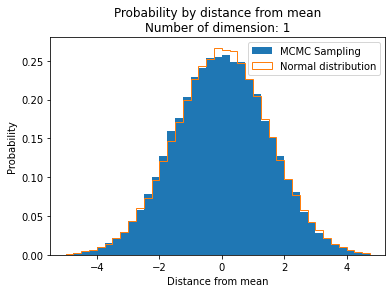

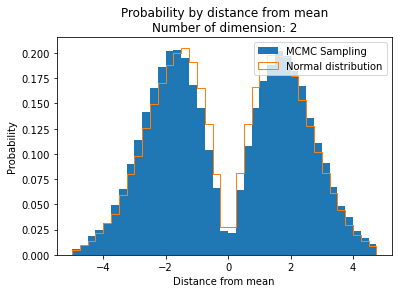

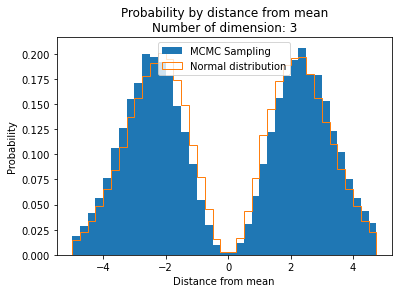

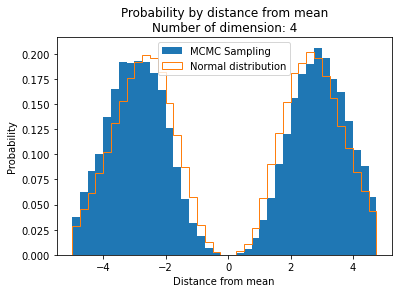

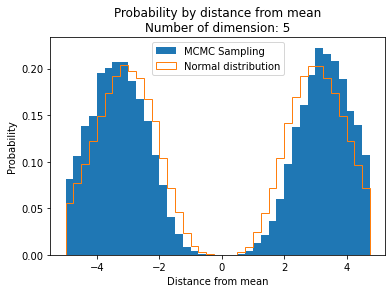

In [2]:
for dimension in range(1,6):
    samples = prepare_mcmc_samples(dimension, 2)
    plot_histograms_by_distance(dimension, samples)


### Now let's see how the number of accepted samples depends on dimension.

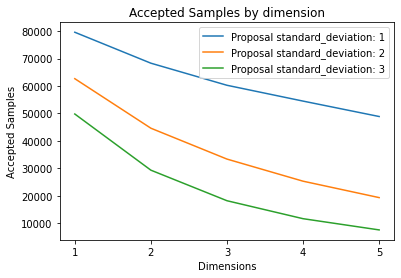

In [3]:
standard_deviations = [1,2,3]
for standard_deviation in standard_deviations:
    x_vals = []
    y_vals = []
    for dimension in range(1,6):
        samples = prepare_mcmc_samples(dimension, standard_deviation)
        x_vals.append(dimension)
        y_vals.append(len(samples))
    plt.plot(x_vals, y_vals, label=f'Proposal standard_deviation: {standard_deviation}')   
plt.xticks(np.arange(1,6))    
plt.xlabel('Dimensions')
plt.ylabel('Accepted Samples')    
plt.title('Accepted Samples by dimension')
plt.legend()
plt.show()

### We see that the number of accepted samples decreases as the dimension increases. I.e., it is
### more difficult to sample a higher dimensional distribution, as expected (the curse of dimensionality).

### Now let us see how the number of accepted samples depends on standard_deviation of the propsal distribution.

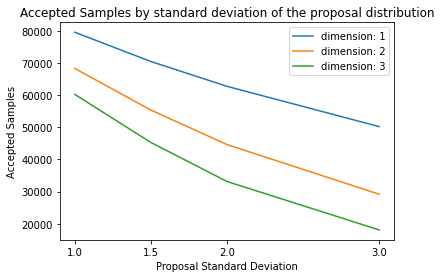

In [4]:
standard_deviations = [1,1.5,2,3]
for dimension in range(1,4):
    x_vals = []
    y_vals = []
    for standard_deviation in standard_deviations:
        samples = prepare_mcmc_samples(dimension, standard_deviation)
        x_vals.append(standard_deviation)
        y_vals.append(len(samples))
    plt.plot(x_vals, y_vals, label=f'dimension: {dimension}')
plt.xticks(standard_deviations)
plt.xlabel('Proposal Standard Deviation')
plt.ylabel('Accepted Samples')    
plt.title('Accepted Samples by standard deviation of the proposal distribution')
plt.legend()
plt.show()

### We see a similar effect with the standard deviation. As the standard deviation of the proposal distribution
### grows larger, we see that we start accepting fewer samples.
### Alternatively, this means that for greater standard deviations, it would take more iterations to achieve
### the same number of accepted samples that Metropolis-Hastings achieves for lower standard deviations
### (in the range (1, 3) in this experiment). I.e., Metropolis-Hastings converges faster for lower standard deviations.
### This, however, doesn't necessarily mean that Metropolis-Hastings the distribution is well-sampled by the
### algorithm, just because it accepted more samples. It could be that for lower standard deviations, the samples
### concentrate around the initial point (1, ..., 1). Further investigation is necessary to determine whether this is
### in fact the case.

### Now lets try another proposal selection strategy: let us perturb one coordinate at a time.
### As shown in a plot below, this strategy works substantially better for dimension ≥ 2

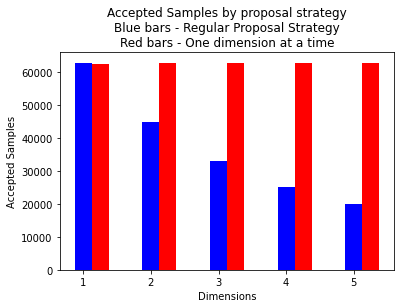

In [5]:
bar_width = 0.25
for dimension in range(1,6):
    samples = prepare_mcmc_samples(dimension, 2)
    plt.bar(dimension, len(samples), width=bar_width, color='blue')
    samples1 = prepare_mcmc_samples_one_coordinate_at_a_time(dimension, 2)
    plt.bar(dimension + bar_width, len(samples1), width=bar_width, color='red')

plt.xticks(np.arange(1,6))
plt.xlabel('Dimensions')
plt.ylabel('Accepted Samples')
plt.title('Accepted Samples by proposal strategy\n' +
          'Blue bars - Regular Proposal Strategy\n' +
          'Red bars - One dimension at a time')
# plt.legend(labels=('Regular proposal selection','One dimension at a time'))
plt.show()


### In addition, using "One coordinate at a time" strategy we get a better fit for the invariant distribution

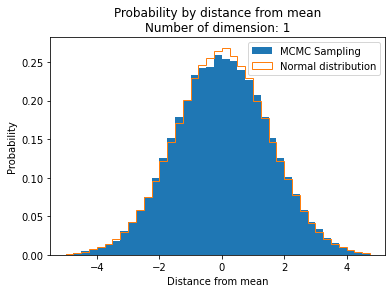

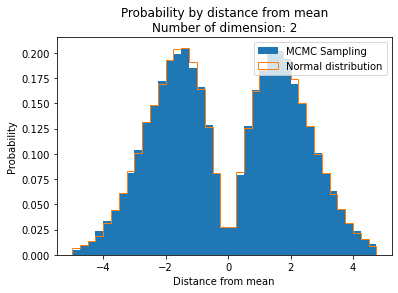

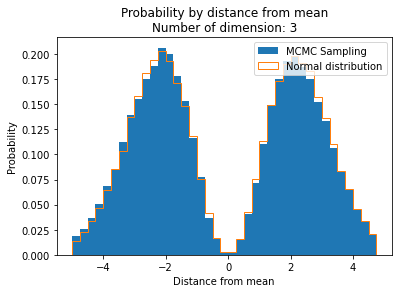

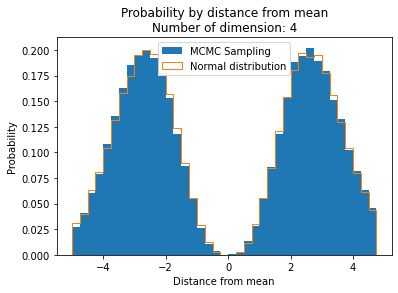

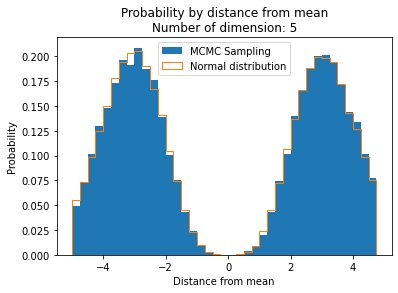

In [6]:
for dimension in range(1,6):
    samples = prepare_mcmc_samples_one_coordinate_at_a_time(dimension, 2)
    plot_histograms_by_distance(dimension, samples)

### We see that this strategy significantly improves sampling, except for dimension 1, where there is no
### significant improvement in sampling, since in dimienssion 1, there is no difference between perturbing
### all coordinates at once, and perturbing one dimension at a time.